In [1]:
%load_ext autoreload

In [66]:
%autoreload 2
import librosa
import os, json, glob
import matplotlib.pyplot as plt
import librosa
from utils import *
from operations import *

## Preprocessing: filter the mono segments
Remove a segment if
1. its duration (after removing leading and trailing zeros) is too short
2. its annotation is empty

In [62]:
# remove a segment if its trimmed duration is shorter than DUR_THRES
# pure silence segments won't be removed by this because they won't be trimmed
# one frame 2048 / 44100 = 0.046 seconds
DUR_THRES = 0.2 # seconds
FILTERED_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/mono_audio_segments_filtered"
FILTERED_ANNO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_single_track_annotations_filtered"

for file in glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav")):
    anno_file = find_anno(file, anno_dir=FILTERED_ANNO_DIR)
    y, sr = librosa.load(file, sr=None)
    y_trimmed, _ = librosa.effects.trim(y)
    dur = librosa.get_duration(y_trimmed, sr=sr)
    if dur < DUR_THRES:
        os.remove(file)
        os.remove(anno_file)
        segment_name = file.split("/")[-1]
        print(f"removed {segment_name}")
# this removed 2315 segments

removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_46_129s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_47_130s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_50_132s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_53_137s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_58_142s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_71_213s.wav
removed Adele - Rolling In The Deep_Acoustic guitar (muted)_0_152s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_49_282s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_50_282s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_51_283s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_52_284s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_53_285s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_54_285s.wav

In [64]:
# remove a segment if its annotation is empty
# many files removed in the last step will also be removed at this step
# pure silence will be removed at this step
FILTERED_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/mono_audio_segments_filtered"
FILTERED_ANNO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_single_track_annotations_filtered"

for file in glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav")):
    anno_file = find_anno(file, anno_dir=FILTERED_ANNO_DIR)
    with open(anno_file) as annotation:
        anno = json.load(annotation)
    if len(anno) == 0:
        os.remove(file)
        os.remove(anno_file)
        segment_name = file.split("/")[-1]
        print(f"removed {segment_name}")
# this removed 4235 segments (when run on its own)
# this removed another 3273 segments (when run after the last cell)

removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_0_3s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_10_20s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_11_21s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_13_25s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_14_26s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_16_30s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_17_31s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_19_35s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_1_5s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_20_36s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_22_40s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_23_41s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_2

## Segment the F0 curve and recognize candidate regions

In [ ]:
MONO_SEGMENTS_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/mono_audio_segments"
ANNO_DIR = (
    "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_single_track_annotations"
)
def find_anno(file, anno_dir=ANNO_DIR):
    segment_name_with_onset, _ = os.path.splitext(file.split("/")[-1])
    segment_name = "_".join(segment_name_with_onset.split("_")[:-1])
    anno_file_name = segment_name + ".json"
    anno_file = os.path.join(anno_dir, anno_file_name)
    return anno_file

def plot_f0_vs_gt(file, audio_dir=MONO_SEGMENTS_DIR, anno_dir=ANNO_DIR):
    file = os.path.join(audio_dir, file)
    y, sr = librosa.load(file, sr=None)
    f0, _, _ = librosa.pyin(
        y, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("E6"), sr=sr, center=False
    )
    times = librosa.times_like(f0, sr=sr, hop_length=512, n_fft=2048)
    notes = librosa.hz_to_midi(f0)

    anno_file = find_anno(file, anno_dir=anno_dir)
    with open(anno_file) as anno:
        note_infos = json.load(anno)

    gt = np.empty_like(notes)
    gt[:] = np.NaN

    for note in note_infos:
        onset = note["time"]["start"] * sr
        offset = (note["time"]["start"] + note["time"]["dur"]) * sr
        onset_fr = librosa.samples_to_frames(onset, hop_length=512)
        offset_fr = librosa.samples_to_frames(offset, hop_length=512)
        gt[onset_fr:offset_fr] = note["pitch"]

    plt.plot(times, notes, label="pYIN", color="blue")
    plt.plot(times, gt, label="GT", color="red")
    plt.legend()
    plt.show()

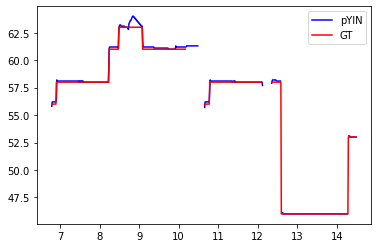

In [75]:
file = "Guns N' Roses - Welcome To The Jungle (ver 3)_Solo Guitar_0_0s.wav"
plot_f0_vs_gt(file)

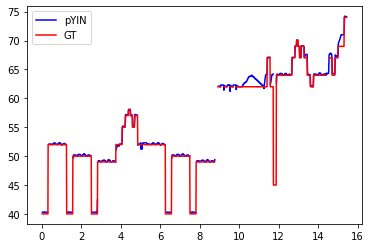

In [74]:
file = "ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_43_105s.wav"
plot_f0_vs_gt(file)